# 第十二週：BERT (Encoder-only-model)

### 1. 套件

連接雲端資料夾

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/My Drive/Colab Notebooks/week12')
os.listdir()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['week12_bert (1).ipynb',
 'TaipeiSansTCBeta-Regular.ttf',
 'raw_data',
 'dict',
 'week12_bert.ipynb']

前處理套件

In [ ]:
# !pip install jieba

In [ ]:
import pandas as pd
import re
import numpy as np
from collections import defaultdict
import multiprocessing
import jieba
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager

# 設定字體
fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
plt.rcParams['font.size'] = '16'

transformers 和 Sentence-transformers （使用 huggingface 模型）

In [ ]:
# !pip install sentence_transformers
# !pip install ckip_transformers

In [ ]:
from transformers import BertTokenizerFast, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification, pipeline
from sentence_transformers import SentenceTransformer
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker

BERTopic

In [ ]:
# !pip install bertopic

In [ ]:
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

### 2. 資料前處理

*載入股市資料集(範圍為5/1 - 5/24)*

In [ ]:
# 股市資料集(範圍為5/1 - 5/24)
origin_data = pd.read_csv('./raw_data/stock_may.csv')

In [ ]:
# 去除一些不需要的欄位
metaData = origin_data.drop(['artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource'], axis=1)
metaData.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

# 只留下中文字
metaData['sentence'] = metaData['artContent'].str.replace(r'\n\n','。', regex=True)
metaData['sentence'] = metaData['sentence'].str.replace(r'\n','', regex=True)

metaData['sentence'] = metaData['sentence'].str.split("[,，。！!？?]{1,}")
metaData = metaData.explode('sentence').reset_index(drop=True)

metaData['sentence'] = metaData['sentence'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

metaData

,system_id,artUrl,artTitle,artDate,artContent,sentence
0,1,https://www.ptt.cc/bbs/Stock/M.1714493279.A.3E...,Re:[標的]5253.JPCOVER你齁484快不行惹,2024-05-01 00:07:56,"你齁有沒有未來不知道,\n\n但看了一下買賣結構就知道,\n基本上就是機構狂做空,\n小散戶...",你齁有沒有未來不知道
1,1,https://www.ptt.cc/bbs/Stock/M.1714493279.A.3E...,Re:[標的]5253.JPCOVER你齁484快不行惹,2024-05-01 00:07:56,"你齁有沒有未來不知道,\n\n但看了一下買賣結構就知道,\n基本上就是機構狂做空,\n小散戶...",但看了一下買賣結構就知道
2,1,https://www.ptt.cc/bbs/Stock/M.1714493279.A.3E...,Re:[標的]5253.JPCOVER你齁484快不行惹,2024-05-01 00:07:56,"你齁有沒有未來不知道,\n\n但看了一下買賣結構就知道,\n基本上就是機構狂做空,\n小散戶...",基本上就是機構狂做空
3,1,https://www.ptt.cc/bbs/Stock/M.1714493279.A.3E...,Re:[標的]5253.JPCOVER你齁484快不行惹,2024-05-01 00:07:56,"你齁有沒有未來不知道,\n\n但看了一下買賣結構就知道,\n基本上就是機構狂做空,\n小散戶...",小散戶
4,1,https://www.ptt.cc/bbs/Stock/M.1714493279.A.3E...,Re:[標的]5253.JPCOVER你齁484快不行惹,2024-05-01 00:07:56,"你齁有沒有未來不知道,\n\n但看了一下買賣結構就知道,\n基本上就是機構狂做空,\n小散戶...",尤其是融資小散戶
...,...,...,...,...,...,...
12265,282,https://www.ptt.cc/bbs/Stock/M.1716737546.A.96...,［請益］2000萬資金運用,2024-05-26 23:32:24,未來六年，每年將獲得長輩贈與的 250。目前手上資產 600，一半是美金定存，剩下是 005...,一邊是枕邊人的強力推薦
12266,282,https://www.ptt.cc/bbs/Stock/M.1716737546.A.96...,［請益］2000萬資金運用,2024-05-26 23:32:24,未來六年，每年將獲得長輩贈與的 250。目前手上資產 600，一半是美金定存，剩下是 005...,這種多變數的問題處理起來有點頭大
12267,282,https://www.ptt.cc/bbs/Stock/M.1716737546.A.96...,［請益］2000萬資金運用,2024-05-26 23:32:24,未來六年，每年將獲得長輩贈與的 250。目前手上資產 600，一半是美金定存，剩下是 005...,想請教各位大神的意見
12268,282,https://www.ptt.cc/bbs/Stock/M.1716737546.A.96...,［請益］2000萬資金運用,2024-05-26 23:32:24,未來六年，每年將獲得長輩贈與的 250。目前手上資產 600，一半是美金定存，剩下是 005...,謝謝


### 3. Token classification

#### 3.1 NER

In [ ]:
model_name = 'ckiplab/bert-base-chinese-ner'
tokenizer = BertTokenizerFast.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

ner_pipe = pipeline('ner', model=model, tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.71k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/407M [00:00<?, ?B/s]

CKIP

In [ ]:
#ckip 工具
ws_driver  = CkipWordSegmenter(model_name="ckiplab/bert-base-chinese-ws", device=0)
pos_driver = CkipPosTagger(model_name="ckiplab/bert-base-chinese-pos", device=0)
ner_driver = CkipNerChunker(model_name="ckiplab/bert-base-chinese-ner", device=0)

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/407M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.86k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/407M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
text = metaData['sentence'].tolist()

# 執行
ws = ws_driver(text)
pos = pos_driver(ws)
ner = ner_driver(text)

# 將斷詞以及 pos 結果合在一起顯示
def pack_ws_pos_sentece(sentence_ws, sentence_pos):
   assert len(sentence_ws) == len(sentence_pos)
   res = []
   for word_ws, word_pos in zip(sentence_ws, sentence_pos):
      res.append(f"{word_ws}({word_pos})")
   return "\u3000".join(res)

sentences, packed_sentences, entities = [], [], []

# 儲存結果
for sentence, sentence_ws, sentence_pos, sentence_ner in zip(text, ws, pos, ner):
   sentences.append(sentence)
   packed_sentences.append(pack_ws_pos_sentece(sentence_ws, sentence_pos))
   entities.append([str(entity) for entity in sentence_ner])

# 將結果存在一個 dataframe 中
ner_results = pd.DataFrame({
   'sentence': sentences,
   'packed_sentence': packed_sentences,
   'entities': entities
})

ner_results
ner_results.to_csv('raw_data/ner_results.csv', index=False)


Inference: 100%|██████████| 47/47 [03:00<00:00,  3.85s/it]


,sentence,packed_sentence,entities
0,你齁有沒有未來不知道,你(Nh) 齁(VC) 有(D) 沒(D) 有(V_2) 未來(Nd) 不(D) 知道(VK),[]
1,但看了一下買賣結構就知道,但(Cbb) 看(VC) 了(Di) 一下(Nd) 買賣(Na) 結構(Na) 就(D) 知...,[]
2,基本上就是機構狂做空,基本(Na) 上(Ng) 就(D) 是(SHI) 機構(Na) 狂(VH) 做空(VA),[]
3,小散戶,小(VH) 散戶(Na),[]
4,尤其是融資小散戶,尤其(D) 是(SHI) 融資(Na) 小(VH) 散戶(Na),[]
...,...,...,...
12265,一邊是枕邊人的強力推薦,一(Neu) 邊(Ncd) 是(SHI) 枕邊人(Na) 的(DE) 強力(D) 推薦(VC),[]
12266,這種多變數的問題處理起來有點頭大,這(Nep) 種(Nf) 多(VH) 變數(Na) 的(DE) 問題(Na) 處理(VC) ...,[]
12267,想請教各位大神的意見,想(VE) 請教(VE) 各位(Nh) 大神(VH) 的(DE) 意見(Na),[]
12268,謝謝,謝謝(VJ),[]


### 4. Sequence classification

#### 4.1 Sentiment Classification
使用 Huggingface 上面已經針對 Sentiment classification 任務 finetune 的 BERT 模型實作

In [ ]:
# 載入已經被 fine-tune 過的 BERT 模型
model_name = "techthiyanes/chinese_sentiment"
model = pipeline('sentiment-analysis', model=model_name)


config.json:   0%|          | 0.00/864 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/409M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

[{'label': 'star 4', 'score': 0.48187997937202454},
 {'label': 'star 1', 'score': 0.24347203969955444}]

In [ ]:
# 建立一個新的 dataframe 來儲存結果
results_df = pd.DataFrame(columns=['sentence', 'label', 'score'])
results_df['sentence'] = metaData['sentence']

# 定義一個函數來進行情緒分析
def analyze_sentiment(sentence):
    result = model([sentence])
    return pd.Series([result[0]['label'], result[0]['score']])

# 使用 apply 函數來進行情緒分析
results_df[['label', 'score']] = metaData['sentence'].apply(analyze_sentiment)

# 輸出結果
results_df

,sentence,label,score
0,你齁有沒有未來不知道,star 1,0.251242
1,但看了一下買賣結構就知道,star 3,0.402388
2,基本上就是機構狂做空,star 2,0.431875
3,小散戶,star 3,0.274647
4,尤其是融資小散戶,star 4,0.538209
...,...,...,...
12265,一邊是枕邊人的強力推薦,star 4,0.620973
12266,這種多變數的問題處理起來有點頭大,star 4,0.434145
12267,想請教各位大神的意見,star 3,0.280388
12268,謝謝,star 4,0.364241


In [ ]:
results_df.to_csv('raw_data/results_df.csv', index=False)

### 5. Text Clustering

In [ ]:
docs = en_origin_data['sentence'].tolist()

# 定義不同 layer 所要使用的模型與方法
embedding_model = "all-MiniLM-L6-v2"
hdbscan_model = HDBSCAN()
vectorizer_model = CountVectorizer()

topic_model = BERTopic(embedding_model=embedding_model, hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model)
topics, probs = topic_model.fit_transform(docs[:500])

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

#### 5.2 Embedding model<br>

In [ ]:
# 使用 sentence_transformers 相關語言模型作為 embedding_model
sentence_model = SentenceTransformer("google-bert/bert-base-uncased")

# 定義不同 layer 所要使用的模型與方法
hdbscan_model = HDBSCAN()
vectorizer_model = CountVectorizer()

# 將 BERTopic 的 embedding_model 替換為其他模型（sentence_model）
embed_topic_model = BERTopic(embedding_model=sentence_model, hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model)
topics, probs = embed_topic_model.fit_transform(docs[:500])

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

#### 5.3 Clustering model<br>

調整 topic modeling 流程中的 clustering 算法

In [ ]:
# 使用 KMeans 作為分群算法，需要指定分群個數
cluster_model = KMeans(n_clusters=10)

# 定義不同 layer 所要使用的模型與方法
embedding_model = "all-MiniLM-L6-v2"
vectorizer_model = CountVectorizer()

# 將 BERTopic 的 hdbscan_model 替換為其他模型（cluster_model）
kmeans_topic_model = BERTopic(embedding_model=embedding_model, hdbscan_model=cluster_model, vectorizer_model=vectorizer_model)
topics, probs = kmeans_topic_model.fit_transform(docs[:500])

kmeans_topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,72,0_you_it_not_do,"[you, it, not, do, but, is, that, to, them, did]","[""It will be no use to us, if twenty such shou..."
1,1,61,1_of_is_to_it,"[of, is, to, it, in, you, are, have, be, the]",[We can all _begin_ freely--a slight preferenc...
2,2,59,2_the_was_her_and,"[the, was, her, and, of, to, she, jane, their,...",[By Jane this attention was received with the ...
3,3,57,3_bennet_of_mrs_mr,"[bennet, of, mrs, mr, the, to, that, said, her...","[""I am astonished, my dear,"" said Mrs. Bennet,..."
4,4,55,4_he_and_the_to,"[he, and, the, to, her, had, was, in, of, his]",[Of this she was perfectly unaware;--to her he...
5,5,54,5_bingley_mr_the_of,"[bingley, mr, the, of, and, was, to, his, her,...","[Bingley intended it likewise, and sometimes m..."
6,6,48,6_darcy_to_lucas_mr,"[darcy, to, lucas, mr, his, the, and, of, sir,...","[And taking her hand, he would have given it t..."
7,7,46,7_you_will_long_not,"[you, will, long, not, have, and, to, she, him...","[But if _we_ do not venture, somebody else wil..."
8,8,28,8_lizzy_dance_eliza_he,"[lizzy, dance, eliza, he, you, the, not, dance...",[He paused in hopes of an answer; but his comp...
9,9,20,9_oh_officers_the_length,"[oh, officers, the, length, severe, ah, connec...","[Oh!, ""Oh!, ""Oh!]"


查看 text clustering 結果

In [ ]:
topics[:10]

[4, 1, 3, 3, 3, 7, 3, 0, 5, 0]

#### 5.4 套用於中文<br>根據多次嘗試的結果進行調整，將輸入筆數改為5000


In [ ]:
# 中文文章
docs_zh = metaData['sentence'].tolist()[:5000]

# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 新增 stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopwords = [line.strip() for line in f.readlines()]

# 設定中文 embedding model
bert_sentence_model = SentenceTransformer("google-bert/bert-base-chinese")

# 將中文文章轉換為 embedding
embeddings = bert_sentence_model.encode(docs_zh, show_progress_bar=True)

# 定義不同 clustering layer 所要使用的模型與方法（就用 default 的 HDBSCAN）
hdbscan_model = HDBSCAN()

# 定義一個適合中文的分詞函數
def tokenize_zh(text):
    words = jieba.lcut(text)
    return words

# 建立一個使用 jieba 分詞的 CountVectorizer
jieba_vectorizer = CountVectorizer(tokenizer=tokenize_zh, stop_words=stopwords, analyzer='word', token_pattern=u"(?u)\\b\\w+\\b")

# 使用 BERTopic 進行主題模型建立
zh_topic_model = BERTopic(embedding_model=bert_sentence_model, vectorizer_model=jieba_vectorizer, verbose=True, top_n_words=30)
topics, probs = zh_topic_model.fit_transform(docs_zh, embeddings)

zh_topic_model.get_topic_info()

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

2024-05-27 14:53:55,855 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-05-27 14:54:10,682 - BERTopic - Dimensionality - Completed ✓
2024-05-27 14:54:10,683 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-05-27 14:54:10,903 - BERTopic - Cluster - Completed ✓
2024-05-27 14:54:10,910 - BERTopic - Representation - Extracting topics from clusters using representation models.
Building prefix dict from /content/drive/MyDrive/Colab Notebooks/week12/dict/dict.txt.big ...
DEBUG:jieba:Building prefix dict from /content/drive/MyDrive/Colab Notebooks/week12/dict/dict.txt.big ...
Loading model from cache /tmp/jieba.u39b4392aeebd568cad6e8c04a61bc98a.cache
DEBUG:jieba:Loading model from cache /tmp/jieba.u39b4392aeebd568cad6e8c04a61bc98a.cache
Loading model cost 1.223 seconds.
DEBUG:jieba:Loading model cost 1.223 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.
2024-05-27 14:54:12,588 - BERTopic

,Topic,Count,Name,Representation,Representative_Docs
0,-1,2498,-1_ _股價_高_台灣,"[ , 股價, 高, 台灣, 投資, 市場, 指數, 台股, 內扣, 買, 賺, 股票, 股...","[隨著台股企業成長, 去年月開始做純短線技術分析就是所謂的追高殺低那時候本金只剩賺和賠大概一..."
1,0,201,0_發電_核二核_核電_核能,"[發電, 核二核, 核電, 核能, 綠能, 綠電, 台灣, 核電廠, 能源, 芬蘭, 延役,...","[原文標題童子賢核二核三延役加新型核電廠台灣電價可降成, 可以為台灣帶來至的核能發電, 可以..."
2,1,110,1_營收_首季_獲利_淨利潤,"[營收, 首季, 獲利, 淨利潤, 新高, 第一季, 去年, 成長, 下降, 個股, 表現,...","[首季獲利不錯的個股, 首季高獲利的個股, 今年首季每股獲利超過元的上市櫃個股]"
3,2,99,2_基金_績效_投資人_報酬率,"[基金, 績效, 投資人, 報酬率, 風險, 息率, 投資, 配息, 未來, 經理人, 避險...","[他也是認為過往基金績效不代表未來績效, 以整體績效指標評估基金績效後, 因為對於基金來說]"
4,3,83,3_贏了_開獎_說_漲,"[贏了, 開獎, 說, 漲, 請問, 賣, 找, 散熱, 難, 工地, 模輸, 絕望, 版模...","[贏了會所嫩模輸了工地版模, 贏了會所嫩模輸了工地版模背債跟閒錢策略不同, 咕嚕咕嚕我是韭菜..."
...,...,...,...,...,...
75,74,12,74_營建_回頭_股_金,"[營建, 回頭, 股, 金, 還未到, 撒, 大買台, 活水, 同梯, 豐台灣, 支援前線,...","[除了營建股, 眼見同梯的兆豐台灣電子成長高息等權重本週一開始募集, 尤其是營建股]"
76,75,12,75_貶值_日元_升值_新台幣,"[貶值, 日元, 升值, 新台幣, 星元, 能源供應, 瑞郎, 澳幣, 歐元, 貶幅, 小於...","[新台幣月貶幅仍小於日元韓元和星元, 新台幣也貶值, 日元更貶值多達]"
77,76,11,76_元_ __,"[元, , , , , , , , , , , , , , , , , , , , , ,...","[元, 元, 元]"
78,77,11,77_至少_放穩_勉強_個性,"[至少, 放穩, 勉強, 個性, 果斷, 一兩個, 要轉, 拿捏, 不合, 就行了, 漲嘛,...","[開始布局長線的至少買一兩個月以上近期的還是會買但是比例自己會抓, 不做空的就至少發現情況不..."


In [ ]:
zh_topic_model.visualize_topics()

查看特定文章的主題分佈

In [ ]:
topic_distr, _ = zh_topic_model.approximate_distribution(docs_zh)

100%|██████████| 5/5 [00:01<00:00,  3.75it/s]


In [ ]:
zh_topic_model.visualize_distribution(topic_distr[20])

第20篇文章可能為topic67或52

In [ ]:
zh_topic_model.get_topic(2)

[('基金', 0.10527912904607774),
 ('績效', 0.07354254462211272),
 ('投資人', 0.05373366889774255),
 ('報酬率', 0.052801970910576146),
 ('風險', 0.05129128805769238),
 ('息率', 0.03631851573020072),
 ('投資', 0.030862436858578216),
 ('配息', 0.029179480790838274),
 ('未來', 0.02870360477046622),
 ('經理人', 0.028502803886615427),
 ('避險', 0.02505990142766997),
 ('選擇', 0.02505990142766997),
 ('差異', 0.02392336598433259),
 ('持續性', 0.02286234408952614),
 ('報酬', 0.02142091988324073),
 ('評估', 0.020694433621851895),
 ('組合', 0.019530968698777632),
 ('指標', 0.01849228664595694),
 ('配', 0.01815925786510036),
 ('提供', 0.017910924198626905),
 ('留意', 0.017600242283963383),
 ('收益', 0.017600242283963383),
 ('商品', 0.017101682331969258),
 ('有助', 0.01654809412447178),
 ('不宜', 0.01654809412447178),
 ('配出', 0.01654809412447178),
 ('前應', 0.01654809412447178),
 ('在乎', 0.01654809412447178),
 ('何種', 0.01654809412447178),
 ('一併', 0.01654809412447178)]

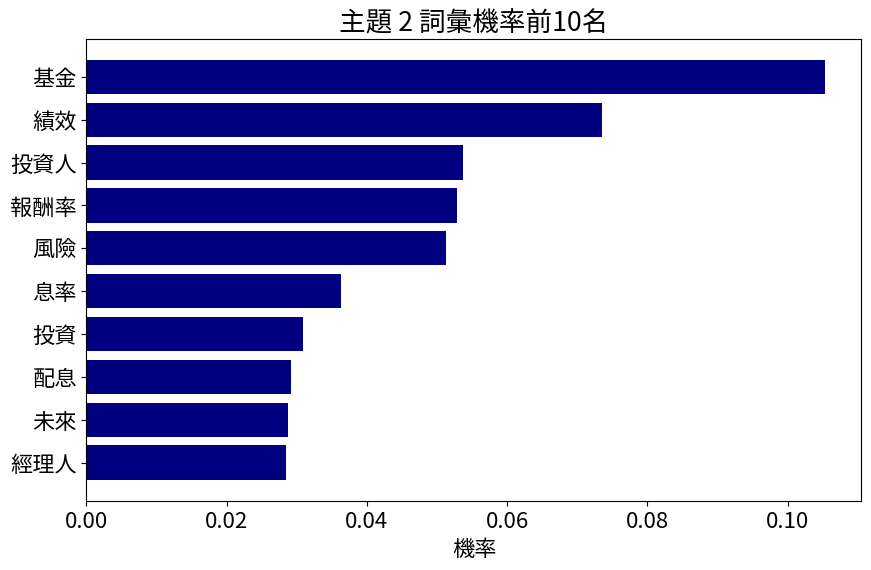

In [ ]:
# 視覺化顯示主題-詞彙分佈
topic_n = 2
data = zh_topic_model.get_topic(topic_n)

# 轉換為DataFrame
df = pd.DataFrame(data, columns=['word', 'prob'])
df = df[df['word'] != ' ']

# 根據prob排序並選出前10名
top_10 = df.sort_values('prob', ascending=False).head(10)

# 畫出長條圖
plt.figure(figsize=(10,6))
plt.barh(top_10['word'], top_10['prob'], color='navy')
plt.xlabel('機率')
plt.title(f'主題 {topic_n} 詞彙機率前10名')
plt.gca().invert_yaxis()
plt.show()

此主題著重在投資相關議題，首先可以看到績效、報酬率、息率、配息等關注利益的詞彙其次為投資主體，例如投資人、經理人等詞彙，最後則是在投資時會關注的面向如未來、風險。<br>我們認為這些詞彙是非常基礎的股市用詞，所以該主題的文章可能是新手或是較不深入的討論